# Import Libraries

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

# 1. Data Reading

In [ ]:
data_dir = ''
data_path = 'export.csv'

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
df = pd.read_csv(data_path)
df['labels'] = df['VOC_CONCEPT'].apply(lambda x: x.split('|'))
df = df[['CELEX', 'Text', 'labels']]
df.head()

,CELEX,Text,labels
0,21972A0722(03),21972A0722(03) Agreement between the European ...,"[Switzerland, trading operation, customs dutie..."
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, tariff policy, agreement (EU), access..."
2,21981A0710(02),21981A0710(02) Exchange of letters between the...,"[Hungary, trade agreement (EU), goatmeat, shee..."
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[trade agreement, Portugal, protocol to an agr..."
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, customs harmonisati..."


# 2. Descriptive Statistics

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257816 entries, 0 to 257815
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   CELEX   257816 non-null  object
 1   Text    257816 non-null  object
 2   labels  257816 non-null  object
dtypes: object(3)
memory usage: 5.9+ MB


## 2.1 Number of Words

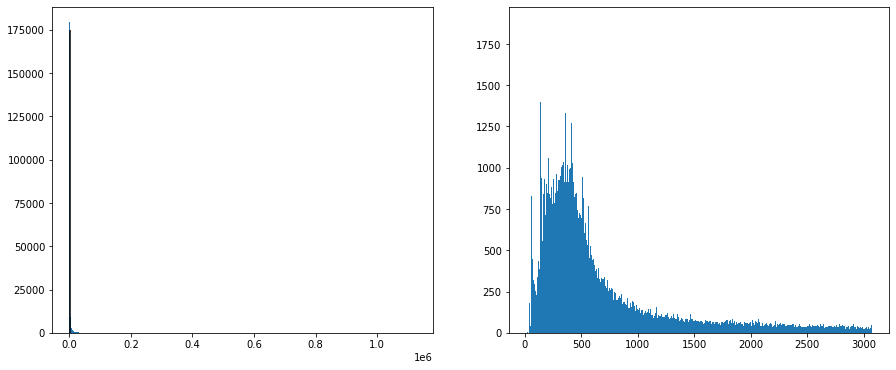

In [ ]:
f, axs = plt.subplots(ncols = 2, figsize = (15, 6))
len_text = df['Text'].apply(lambda x: len(str(x).split())).values
axs[0].hist(len_text, bins=1000)
axs[0].vlines(3072, 0, 175000, color='black')
axs[1].hist(len_text[len_text < 3072], bins=1000)
plt.show()

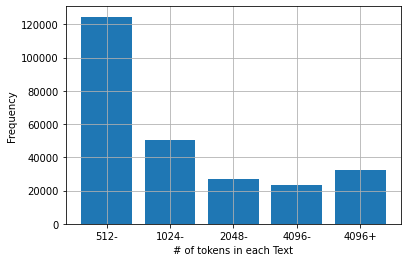

In [ ]:
len_words = []
cnt = 0
num_tokens = [512, 1024,2048,4096]
for i in num_tokens:
    cnt1 = len(len_text[len_text<i])
    len_words.append(cnt1-cnt)
    cnt = cnt1
    
len_words.append(len(len_text[len_text>=i]))
num_tokens = [str(token)+'-' for token in num_tokens]
num_tokens.append('4096+')
plt.bar(height = len_words, x = np.arange(5))
plt.xticks(np.arange(5), num_tokens)
plt.grid()
plt.ylabel('Frequency')
plt.xlabel('# of tokens in each Text')
plt.show()

## 2.2 Label Frequency

In [ ]:
label_dicts = defaultdict(int)
for labels in df['labels']:
    for label in labels:
        label_dicts[label]+=1
labels = pd.Series(label_dicts).to_frame()
labels.rename(columns={0:'cnt'}, inplace = True)
labels['category'] = pd.cut(labels['cnt'], bins = [0, 1, 10, 50, 100, 500, 1000, 2500, 5000, 10000, 15000], labels = ['1label','10labels', '50labels', '100labels', '500labels', '1000labels', '2500labels', '5000labels', '10000labels', '15000labels',])
labels.sort_values(by='cnt')

,cnt,category
political philosophy,1,1label
South Asian Association for Regional Cooperation,1,1label
non-European language,1,1label
electorate,1,1label
multiple office holding,1,1label
...,...,...
control of State aid,9240,10000labels
European Commission,9860,10000labels
State aid,11785,15000labels
merger control,12488,15000labels


In [ ]:
labels.groupby('category')['category'].count().to_frame()

,category
category,
1label,339
10labels,1313
50labels,1838
100labels,885
500labels,1582
1000labels,400
2500labels,245
5000labels,64
10000labels,24


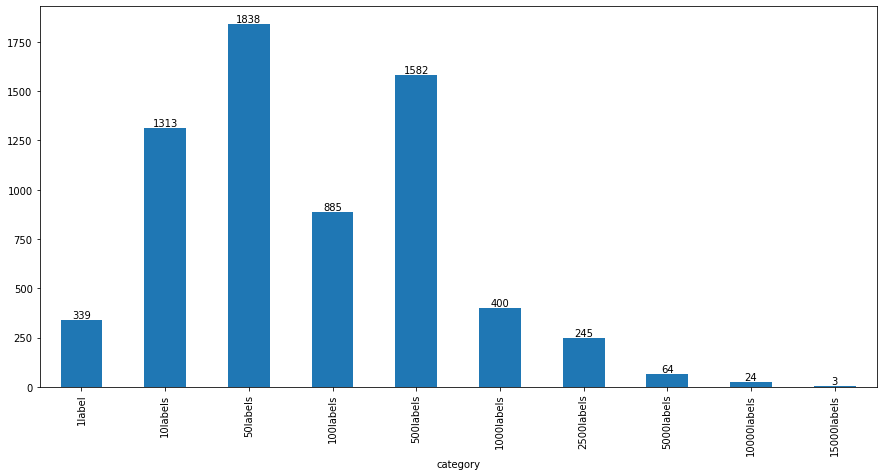

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
ax = labels.groupby('category')['category'].count().plot.bar()
ax.bar_label(ax.containers[0])
plt.show()

## 2.3 Filtering out less frequently labels

In [ ]:
filtered_labels = set(labels[(labels['category']== '15000labels') | 
                             (labels['category']== '10000labels') |
                             (labels['category']== '5000labels')].index)
len(filtered_labels)

91

In [ ]:
df['check_labels'] = df['labels'].apply(lambda x: any(label in filtered_labels for label in x))
drops, keeps = np.unique(df['check_labels'], return_counts = True)

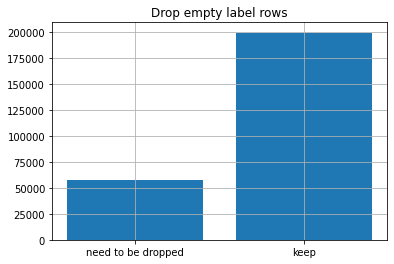

In [ ]:
plt.bar(drops, keeps)
plt.xticks([0, 1], ['need to be dropped', 'keep'])
plt.grid()
plt.title('Drop empty label rows')
plt.show()

In [ ]:
df = df[df['check_labels']]
df['labels'] = df['labels'].apply(lambda x: [label for label in x if label in filtered_labels])
df.drop('check_labels', axis=1, inplace = True)
df.reset_index(drop=True, inplace = True)
df.head()

,CELEX,Text,labels
0,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, agreement (EU), accession to the Euro..."
1,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[Portugal, protocol to an agreement, accession..."
2,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, revision of an agre..."
3,21987D0411(04),21987D0411(04) Decision No 3/86 of the EEC-Swe...,[originating product]
4,21987D0411(05),21987D0411(05) Decision No 3/86 of the EEC-Swi...,[originating product]


## 2.4 Save result dataframe as CSV file

In [ ]:
df.to_csv('filtered_export.csv', index = False)